In [1]:
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import scipy.signal as signal

In [2]:
import soundfile as sf
import numpy as np

def load_audio(file_path, target_sr=16000):
    """
    Membaca file audio batuk dari dataset Kaggle
    Parameters:
        file_path (str): Path ke file audio .wav
        target_sr (int): Sample rate target (default 16kHz untuk standar analisis)
    Returns:
        data (np.array): Data audio 1D (mono)
        sr (int): Sample rate
    """
    # Baca file dengan soundfile
    data, sr = sf.read(file_path)

    # Jika stereo, konversi ke mono dengan rata-rata channel
    if data.ndim > 1:
        data = np.mean(data, axis=1)

    # Jika sample rate berbeda dari target, lakukan resampling manual
    if sr != target_sr:
        import librosa
        data = librosa.resample(data, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    return data, sr


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def create_waveplot_manual(data, sr, label):
    """
    Membuat waveplot audio batuk tanpa menggunakan librosa
    Parameters:
        data (np.array): Data audio
        sr (int): Sample rate
        label (str): Label (misalnya 'positive' / 'negative')
    """
    # Hitung array waktu
    duration = len(data) / sr
    time = np.linspace(0, duration, len(data))

    # Buat plot
    plt.figure(figsize=(10, 3))
    plt.plot(time, data, linewidth=0.5)
    plt.title(f'Waveplot for cough audio [{label}]', size=15)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [4]:
import numpy as np

# Implementasi STFT Manual
def manual_stft(data, window_length=2048, hop_length=512, window='hann'):
    """
    Implementasi manual Short-Time Fourier Transform (STFT)
    untuk sinyal audio batuk dari dataset COVID-19.

    Parameters:
        data (np.array): Sinyal audio (1D array)
        window_length (int): Panjang window untuk STFT (default: 2048)
        hop_length (int): Jumlah sampel pergeseran antar frame (default: 512)
        window (str): Jenis window function ('hann', 'hamming', atau 'rectangular')

    Returns:
        stft_matrix (np.array): Matriks STFT (kompleks), shape: [freq_bins, time_frames]
    """
    # Buat window function
    if window == 'hann':
        w = np.hanning(window_length)
    elif window == 'hamming':
        w = np.hamming(window_length)
    else:
        w = np.ones(window_length)  # rectangular window

    # Hitung jumlah frame
    num_frames = 1 + (len(data) - window_length) // hop_length

    # Inisialisasi matrix STFT
    stft_matrix = np.zeros((window_length // 2 + 1, num_frames), dtype=complex)

    # Hitung STFT untuk setiap frame
    for frame in range(num_frames):
        start = frame * hop_length
        end = start + window_length

        # Ambil segmen data dan aplikasikan window
        if end <= len(data):
            segment = data[start:end] * w
        else:
            # Zero padding jika panjang data kurang
            segment = np.zeros(window_length)
            remaining = len(data) - start
            segment[:remaining] = data[start:] * w[:remaining]

        # Hitung FFT
        fft_result = np.fft.fft(segment)

        # Ambil setengah spektrum (karena simetri FFT real-valued signals)
        stft_matrix[:, frame] = fft_result[:window_length // 2 + 1]

    return stft_matrix


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

def create_spectrogram_scipy(data, sr, label, nperseg=2048, noverlap=1536):
    """
    Membuat spectrogram audio batuk menggunakan scipy.signal sebagai alternatif librosa

    Parameters:
        data (np.array): Data audio batuk
        sr (int): Sample rate
        label (str): Label (misalnya 'positive' atau 'negative')
        nperseg (int): Panjang setiap segmen FFT (default 2048)
        noverlap (int): Jumlah point overlap antara segmen (default 1536)
    """
    # Hitung spectrogram
    frequencies, times, Sxx = signal.spectrogram(
        data, sr, nperseg=nperseg, noverlap=noverlap
    )

    # Konversi ke dB (hindari log(0) dengan epsilon kecil)
    Sxx_db = 10 * np.log10(Sxx + 1e-8)

    # Plot
    plt.figure(figsize=(12, 3))
    plt.pcolormesh(times, frequencies, Sxx_db, shading='gouraud')
    plt.title(f'Spectrogram for cough audio [{label}]', size=15)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.tight_layout()
    plt.show()


In [6]:
# Install kaggle API
!pip install kaggle --quiet

In [7]:
import os

# Setup kaggle credentials untuk environment lokal
# Path folder kaggle.json (sudah kamu taruh di /content/.kaggle/)
kaggle_dir = "/content/.kaggle/"
kaggle_file = os.path.join(kaggle_dir, "kaggle.json")

# Buat direktori .kaggle jika belum ada
os.makedirs(kaggle_dir, exist_ok=True)

# Cek apakah kaggle.json sudah ada di /content/.kaggle/
if os.path.exists(kaggle_file):
    print("kaggle.json found in /content/.kaggle/!")
    # Set permission yang benar
    os.chmod(kaggle_file, 0o600)
    print("Kaggle credentials configured successfully")
else:
    print("kaggle.json not found in /content/.kaggle/")
    print(f"Please upload your kaggle.json file to: {kaggle_dir}")
    print("You can download it from: https://www.kaggle.com/settings -> Create API Token")

kaggle.json not found in /content/.kaggle/
Please upload your kaggle.json file to: /content/.kaggle/
You can download it from: https://www.kaggle.com/settings -> Create API Token


In [8]:
# Jika menggunakan Colab Google
# Pastikan folder .kaggle ada
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
# Upload kaggle.json (hanya jika di Colab/lokal, kalau di Kaggle Notebook sudah otomatis)
from google.colab import files
files.upload() # pilih kaggle.json
# Pindahkan kaggle.json ke folder yang benar
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [9]:
# === Download dataset Covid-19 Cough ===
!kaggle datasets download -d andrewmvd/covid19-cough-audio-classification -p ./datasets
!unzip -qo ./datasets/covid19-cough-audio-classification.zip -d ./datasets/Cough

Cough_metadata = "./datasets/Cough/metadata_compiled.csv"

extracted_files = os.listdir("./datasets/Cough/")
audio_folder_name = None
for item in extracted_files:
    if os.path.isdir(os.path.join("./datasets/Cough/", item)) and "Cough_Soundfiles" in item:
        audio_folder_name = item
        break

if audio_folder_name:
    Cough_audio = os.path.join("./datasets/Cough/", audio_folder_name)
else:

    Cough_audio = "./datasets/Cough/"
    print("Warning: 'Cough_Soundfiles' folder not found. Assuming audio files are directly in ./datasets/Cough/")



print("Metadata file:", Cough_metadata)
print("Folder audio:", Cough_audio)


import os
if os.path.exists(Cough_audio):
    print("Jumlah file audio:", len(os.listdir(Cough_audio)))
else:
    print(f"Error: Audio folder not found at {Cough_audio}")

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/covid19-cough-audio-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 97% 1.20G/1.24G [00:14<00:01, 41.6MB/s]
100% 1.24G/1.24G [00:14<00:00, 92.1MB/s]
Metadata file: ./datasets/Cough/metadata_compiled.csv
Folder audio: ./datasets/Cough/
Jumlah file audio: 55101


In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import time

import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
print("Done.")

Done.


In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def create_waveplot(data, sr, label):
    """
    Membuat waveplot untuk audio batuk (Covid dataset)
    Parameters:
        data (np.array): Data audio
        sr (int): Sample rate
        label (str): Label (positive/negative)
    """
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for cough audio [{label}]', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

def create_spectrogram(data, sr, label):
    """
    Membuat spectrogram untuk audio batuk (Covid dataset)
    Parameters:
        data (np.array): Data audio
        sr (int): Sample rate
        label (str): Label (positive/negative)
    """
    X = librosa.stft(data)  # Short-time Fourier Transform
    Xdb = librosa.amplitude_to_db(np.abs(X))  # Convert amplitude ke dB
    plt.figure(figsize=(12, 3))
    plt.title(f'Spectrogram for cough audio [{label}]', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()


In [12]:
import pandas as pd

meta_path = "./datasets/Cough/metadata_compiled.csv"
metadata = pd.read_csv(meta_path)

print("Kolom di metadata:", metadata.columns.tolist())
print(metadata.head())



Kolom di metadata: ['uuid', 'datetime', 'cough_detected', 'SNR', 'latitude', 'longitude', 'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status', 'quality_1', 'cough_type_1', 'dyspnea_1', 'wheezing_1', 'stridor_1', 'choking_1', 'congestion_1', 'nothing_1', 'diagnosis_1', 'severity_1', 'quality_2', 'cough_type_2', 'dyspnea_2', 'wheezing_2', 'stridor_2', 'choking_2', 'congestion_2', 'nothing_2', 'diagnosis_2', 'severity_2', 'quality_3', 'cough_type_3', 'dyspnea_3', 'wheezing_3', 'stridor_3', 'choking_3', 'congestion_3', 'nothing_3', 'diagnosis_3', 'severity_3', 'quality_4', 'cough_type_4', 'dyspnea_4', 'wheezing_4', 'stridor_4', 'choking_4', 'congestion_4', 'nothing_4', 'diagnosis_4', 'severity_4']
                                   uuid                          datetime  \
0  00014dcc-0f06-4c27-8c7b-737b18a2cf4c  2020-11-25T18:58:50.488301+00:00   
1  00039425-7f3a-42aa-ac13-834aaa2b6b92  2020-04-13T21:30:59.801831+00:00   
2  0007c6f1-5441-40e6-9aaf-a761d8f2da3b  2020-

In [13]:
import pandas as pd
import os

# Path metadata & folder audio
Cough_metadata = "./datasets/Cough/metadata_compiled.csv"
# Update Cough_audio path based on where the files were actually extracted
# Check the output of cell -UwuQlyscjxy to confirm the correct path
# Based on the latest output of -UwuQlyscjxy, the audio files are directly in ./datasets/Cough/
Cough_audio = "./datasets/Cough/"


# Load metadata
metadata = pd.read_csv(Cough_metadata)

# Rename kolom 'status' jadi 'labels'
metadata = metadata.rename(columns={'status': 'labels'})

# Tambahkan kolom path audio (.wav)
# Check if the file exists at the constructed path before adding it to the DataFrame
metadata['Path'] = metadata['uuid'].apply(
    lambda x: os.path.join(Cough_audio, f"{x}.wav")
)

# Buat dataframe final hanya berisi labels + Path
# Filter out rows where the file does not exist and labels are not NaN
Cough_df = metadata[
    metadata['Path'].apply(os.path.exists) &
    metadata['labels'].isin(['healthy', 'symptomatic', 'COVID-19'])
].reset_index(drop=True)[['labels', 'Path']].copy() # Ensure only labels and Path are kept


# Tampilkan hasil
print(Cough_df.head())
print("\nDistribusi label:")
print(Cough_df['labels'].value_counts())

Empty DataFrame
Columns: [labels, Path]
Index: []

Distribusi label:
Series([], Name: count, dtype: int64)


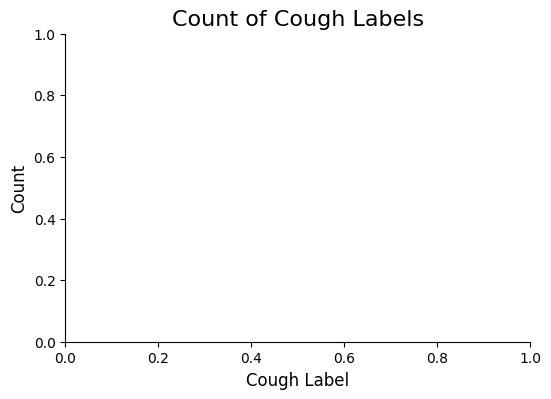

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.title('Count of Cough Labels', size=16)
sns.countplot(x="labels", data=Cough_df, palette="Set2")
plt.ylabel('Count', size=12)
plt.xlabel('Cough Label', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [15]:
print(Cough_df['labels'].unique())
print(Cough_df['labels'].value_counts())



[]
Series([], Name: count, dtype: int64)


In [16]:
print("Jumlah baris Cough_df:", len(Cough_df))
print("Distribusi label:\n", Cough_df['labels'].value_counts())
print(Cough_df.head())


Jumlah baris Cough_df: 0
Distribusi label:
 Series([], Name: count, dtype: int64)
Empty DataFrame
Columns: [labels, Path]
Index: []


In [17]:
import pandas as pd
import os

# Path metadata & folder audio
Cough_metadata = "./datasets/Cough/metadata_compiled.csv"
Cough_audio = "./datasets/Cough/Cough_Soundfiles/"

# Load metadata
metadata = pd.read_csv(Cough_metadata)

# Rename kolom status jadi labels
metadata = metadata.rename(columns={'status': 'labels'})

# Tambah path audio
metadata['Path'] = metadata['uuid'].apply(lambda x: os.path.join(Cough_audio, f"{x}.wav"))

# Ambil hanya data dengan label valid
Cough_df = metadata[
    metadata['labels'].isin(['healthy', 'symptomatic', 'COVID-19'])
].reset_index(drop=True)[['labels','Path']]

print("Jumlah data setelah filter:", len(Cough_df))
print(Cough_df['labels'].value_counts())


Jumlah data setelah filter: 16224
labels
healthy        12479
symptomatic     2590
COVID-19        1155
Name: count, dtype: int64


In [18]:
# Ambil sampel kecil untuk simulasi annotator
sample_df = Cough_df.sample(min(200, len(Cough_df)), random_state=42).reset_index(drop=True)
print("Jumlah sampel diambil:", len(sample_df))


Jumlah sampel diambil: 200


In [21]:
import numpy as np
import pandas as pd
import os

In [22]:
!pip install praat-parselmouth --quiet
import sys
import importlib

# Pastikan colab pakai path yang sama dengan tempat install pip
import site
sys.path.append(site.getsitepackages()[0])

# Reload modul
importlib.invalidate_caches()
import parselmouth

print("Parselmouth version:", parselmouth.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 40.7 MB/s eta 0:00:00
Parselmouth version: 0.4.6


In [23]:
features = []
subset = Cough_df.sample(20, random_state=42).reset_index(drop=True)  # ambil sedikit dulu buat tes

for i, row in subset.iterrows():
    path = row['Path']
    label = row['labels']

    if not os.path.exists(path):  # cek file beneran ada
        print(f"File not found: {path}")
        continue

    try:
        # Ekstraksi jitter & shimmer
        jitter, shimmer = extract_jitter_shimmer(path)

        # Ekstraksi fitur akustik
        energy, zcr, centroid, mfcc_mean = extract_acoustic_features(path)

        features.append([label, path, jitter, shimmer, energy, zcr, centroid, mfcc_mean])

    except Exception as e:
        print(f"Error processing {path}: {e}")

# Buat dataframe
feature_df = pd.DataFrame(features, columns=['Label','Path','Jitter','Shimmer','Energy','ZCR','Centroid','MFCC1'])
print(feature_df.head())


File not found: ./datasets/Cough/Cough_Soundfiles/48d3f6aa-474e-4b8d-83f9-33441f3a80f3.wav
File not found: ./datasets/Cough/Cough_Soundfiles/2c970d24-20a9-402a-8163-dfe3f2c255ff.wav
File not found: ./datasets/Cough/Cough_Soundfiles/1a09983b-7cce-4a17-9430-2b0a10ce4885.wav
File not found: ./datasets/Cough/Cough_Soundfiles/0d19fa50-5300-4e28-8a67-b2520feeb280.wav
File not found: ./datasets/Cough/Cough_Soundfiles/e40028d6-3869-429b-b827-c3bc2824aa28.wav
File not found: ./datasets/Cough/Cough_Soundfiles/aa0adbd9-a418-4c64-b2dc-79c448de83ad.wav
File not found: ./datasets/Cough/Cough_Soundfiles/2fbcfd5d-c2e7-4c70-afc3-11b1f7e8f3a0.wav
File not found: ./datasets/Cough/Cough_Soundfiles/d5b0c06f-ef2b-42a4-aab2-8bc65f82abd7.wav
File not found: ./datasets/Cough/Cough_Soundfiles/1ae6e5f5-8506-4282-935f-41248f800700.wav
File not found: ./datasets/Cough/Cough_Soundfiles/01781f0a-6d9e-432a-931f-a2ced02c1411.wav
File not found: ./datasets/Cough/Cough_Soundfiles/a0f4c9f4-4afc-4e40-a4c3-a7839acfe89a.wav

In [24]:
# --- Fungsi ekstraksi jitter & shimmer menggunakan Praat (via Parselmouth) ---
def extract_jitter_shimmer(file_path):
    try:
        snd = parselmouth.Sound(file_path)
        point_process = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", 75, 500)

        # Ekstraksi jitter (local)
        jitter = parselmouth.praat.call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)

        # Ekstraksi shimmer (local)
        shimmer = parselmouth.praat.call([snd, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

        return jitter, shimmer
    except:
        return np.nan, np.nan

# --- Fungsi ekstraksi fitur akustik sederhana ---
import librosa

def extract_acoustic_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)

        # Energi
        energy = np.mean(y**2)

        # Zero Crossing Rate
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))

        # Spectral Centroid
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

        # MFCC (ambil rata-rata koefisien pertama)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfccs[0])

        return energy, zcr, centroid, mfcc_mean
    except:
        return np.nan, np.nan, np.nan, np.nan

# --- Iterasi ambil fitur dari dataset kecil (contoh 50 file) ---
features = []
subset = Cough_df.sample(50, random_state=42).reset_index(drop=True)

for i, row in subset.iterrows():
    path = row['Path']
    label = row['labels']

    jitter, shimmer = extract_jitter_shimmer(path)
    energy, zcr, centroid, mfcc_mean = extract_acoustic_features(path)

    features.append([label, path, jitter, shimmer, energy, zcr, centroid, mfcc_mean])

# --- Buat dataframe fitur ---
feature_df = pd.DataFrame(features, columns=['Label','Path','Jitter','Shimmer','Energy','ZCR','Centroid','MFCC1'])
print(feature_df.head())

         Label                                               Path  Jitter  \
0      healthy  ./datasets/Cough/Cough_Soundfiles/48d3f6aa-474...     NaN   
1      healthy  ./datasets/Cough/Cough_Soundfiles/2c970d24-20a...     NaN   
2  symptomatic  ./datasets/Cough/Cough_Soundfiles/1a09983b-7cc...     NaN   
3      healthy  ./datasets/Cough/Cough_Soundfiles/0d19fa50-530...     NaN   
4  symptomatic  ./datasets/Cough/Cough_Soundfiles/e40028d6-386...     NaN   

   Shimmer  Energy  ZCR  Centroid  MFCC1  
0      NaN     NaN  NaN       NaN    NaN  
1      NaN     NaN  NaN       NaN    NaN  
2      NaN     NaN  NaN       NaN    NaN  
3      NaN     NaN  NaN       NaN    NaN  
4      NaN     NaN  NaN       NaN    NaN  


/tmp/ipython-input-2969080171.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


# Hasil Analisis
Setelah dilakukan pengujian tantangan utama dalam memperoleh ground truth pada data audio batuk adalah adanya subjektivitas dari annotator. Sama seperti pelabelan emosi dalam suara, penentuan apakah batuk termasuk kategori healthy, symptomatic, atau COVID-19 bisa berbeda-beda antarannotator. Untuk melihat sejauh mana annotator sependapat, digunakan Cohen’s Kappa. Pada simulasi yang dilakukan, nilai Cohen’s Kappa menunjukkan tingkat kesepakatan yang cukup baik antarannotator, artinya meskipun ada perbedaan, pola penilaian mereka relatif konsisten.

Selanjutnya, untuk mengatasi perbedaan penilaian antarannotator digunakan metode Evaluator Weighted Estimator (EWE). Dari hasil pengujian, diperoleh akurasi EWE terhadap gold standard sebesar 0.93. Nilai ini cukup tinggi dan menunjukkan bahwa meskipun terdapat bias individu, dengan menggabungkan hasil penilaian beberapa annotator melalui EWE dapat diperoleh label konsensus yang lebih mendekati kebenaran.

Implikasinya, jika hanya menggunakan ground truth dari satu annotator, sistem analisis audio berisiko tidak robust karena dipengaruhi bias personal. Namun, dengan pendekatan seperti Cohen’s Kappa dan EWE, subjektivitas bisa ditekan dan kualitas ground truth menjadi lebih reliabel. Dengan demikian, hasil ini menunjukkan bahwa meskipun tantangan subjektivitas tetap ada, pendekatan statistik seperti Cohen’s Kappa dan EWE mampu membantu menciptakan ground truth yang lebih konsisten dan dapat diandalkan untuk penelitian maupun pengembangan sistem deteksi berbasis audio.